In [20]:
import pandas as pd 
import numpy as np 
import plotly.express as px
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import datetime
import seaborn as sns

import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
plt.figure(figsize = (18, 9))
plt.style.use(['fast', 'seaborn-whitegrid'])

<Figure size 1296x648 with 0 Axes>

In [2]:
train = pd.read_csv('DA1920_train.csv')
store = pd.read_csv('clean_store.csv')
train.shape
train.head()

C:\Users\ke117\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3044: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,31/07/2015,5263,555,1,1,0,1
1,2,5,31/07/2015,6064,625,1,1,0,1
2,3,5,31/07/2015,8314,821,1,1,0,1
3,4,5,31/07/2015,13995,1498,1,1,0,1
4,5,5,31/07/2015,4822,559,1,1,0,1


In [3]:
train.dtypes
train['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [4]:
train['StateHoliday'] = train['StateHoliday'].replace(['0'], 0)

In [5]:
store.isna().any()
store = store.drop(['Promofactor', 'Assortfactor', 'PromoYear'], axis = 1)

In [6]:
merge = pd.merge(train, store, on = 'Store', how = 'inner')

In [7]:
merge.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Unnamed: 0,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,31/07/2015,5263,555,1,1,0,1,1,c,a,1270,9,2008,0,x,x,x
1,1,4,30/07/2015,5020,546,1,1,0,1,1,c,a,1270,9,2008,0,x,x,x
2,1,3,29/07/2015,4782,523,1,1,0,1,1,c,a,1270,9,2008,0,x,x,x
3,1,2,28/07/2015,5011,560,1,1,0,1,1,c,a,1270,9,2008,0,x,x,x
4,1,1,27/07/2015,6102,612,1,1,0,1,1,c,a,1270,9,2008,0,x,x,x


In [8]:
# merge.to_csv('allstore.csv', index = False)

In [9]:
df = pd.read_csv('allstore.csv')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Unnamed: 0,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,31/07/2015,5263,555,1,1,0,1,1,c,a,1270,9,2008,0,x,x,x
1,1,4,30/07/2015,5020,546,1,1,0,1,1,c,a,1270,9,2008,0,x,x,x
2,1,3,29/07/2015,4782,523,1,1,0,1,1,c,a,1270,9,2008,0,x,x,x
3,1,2,28/07/2015,5011,560,1,1,0,1,1,c,a,1270,9,2008,0,x,x,x
4,1,1,27/07/2015,6102,612,1,1,0,1,1,c,a,1270,9,2008,0,x,x,x


In [10]:
df.isnull().any()
df = df.drop(['Unnamed: 0'], axis = 1)

# Feature engineering 

In [11]:
# Dates 
df['Date'] = pd.to_datetime(df['Date'])
df['quarter'] = df['Date'].apply(lambda x: x.quarter)

df['weekday'] = df.apply(lambda row: row['Date'].weekday(), axis = 1)
df['weekday'] = (df['weekday'] < 5).astype(int)

df.set_index('Date', inplace = True)

df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['week_of_year'] = df.index.weekofyear

df['day_of_year'] = df.index.dayofyear
df['day_of_week'] = df.index.dayofweek
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceYear,PromoInterval,quarter,weekday,year,month,day,week_of_year,day_of_year,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,c,a,...,x,x,3,1,2015,7,31,31,212,4
2015-07-30,1,4,5020,546,1,1,0,1,c,a,...,x,x,3,1,2015,7,30,31,211,3
2015-07-29,1,3,4782,523,1,1,0,1,c,a,...,x,x,3,1,2015,7,29,31,210,2
2015-07-28,1,2,5011,560,1,1,0,1,c,a,...,x,x,3,1,2015,7,28,31,209,1
2015-07-27,1,1,6102,612,1,1,0,1,c,a,...,x,x,3,1,2015,7,27,31,208,0


# Kurtosis & Skewness
- kurtosis close to 0 = Normal
- Skewness between -0.5 & 0.5 = symmetry 

Kurtosis:1.778360107320018
Skewness:0.6414586698987553


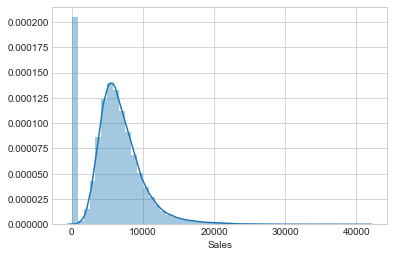

In [21]:
sns.distplot(df.Sales);

print('Kurtosis:{}'.format(stats.kurtosis(df.Sales)))
print('Skewness:{}'.format(stats.skew(df.Sales)))

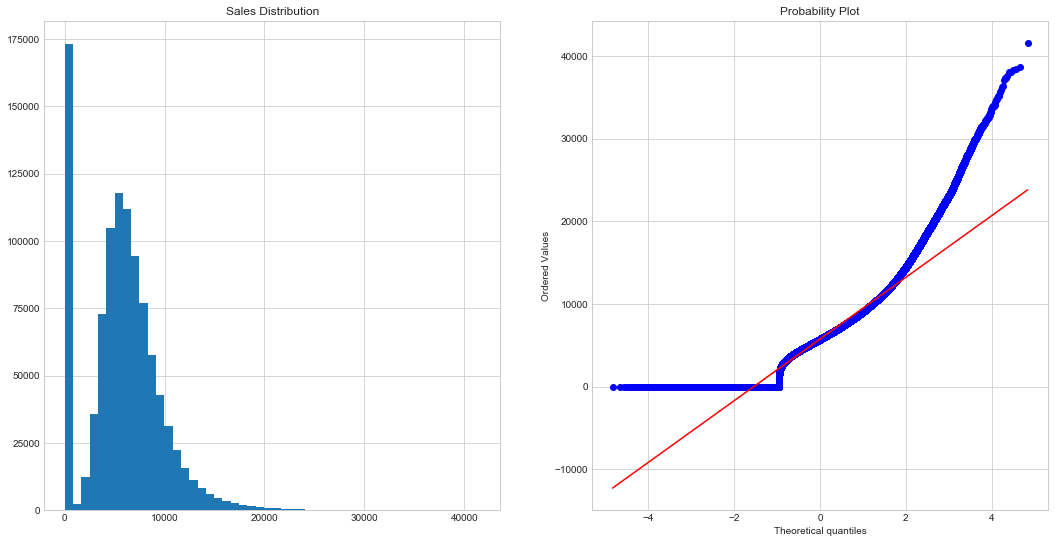

In [23]:
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
df['Sales'].hist(bins=50)
plt.title('Sales Distribution')
plt.subplot(1,2,2)
stats.probplot(df['Sales'], plot=plt);

# Does not look normally distributed 

# Resampling over time 

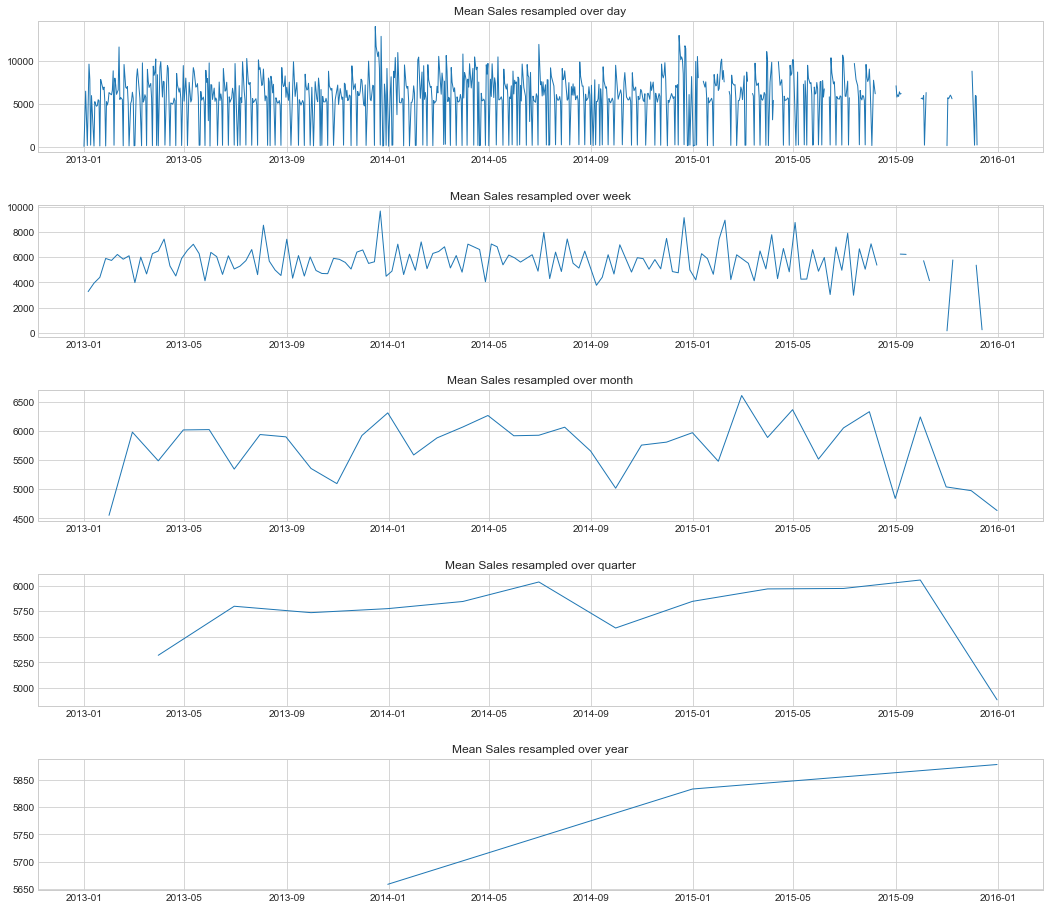

In [30]:
df1 = df.loc[:, ['Date', 'Sales']]

fig = plt.figure(figsize=(18, 16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Sales'].resample('D').mean(),linewidth = 1)
ax1.set_title('Mean Sales resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Sales'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Sales resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Sales'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Sales resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Sales'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Sales resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Sales'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Sales resampled over year')
ax5.tick_params(axis='both', which='major');

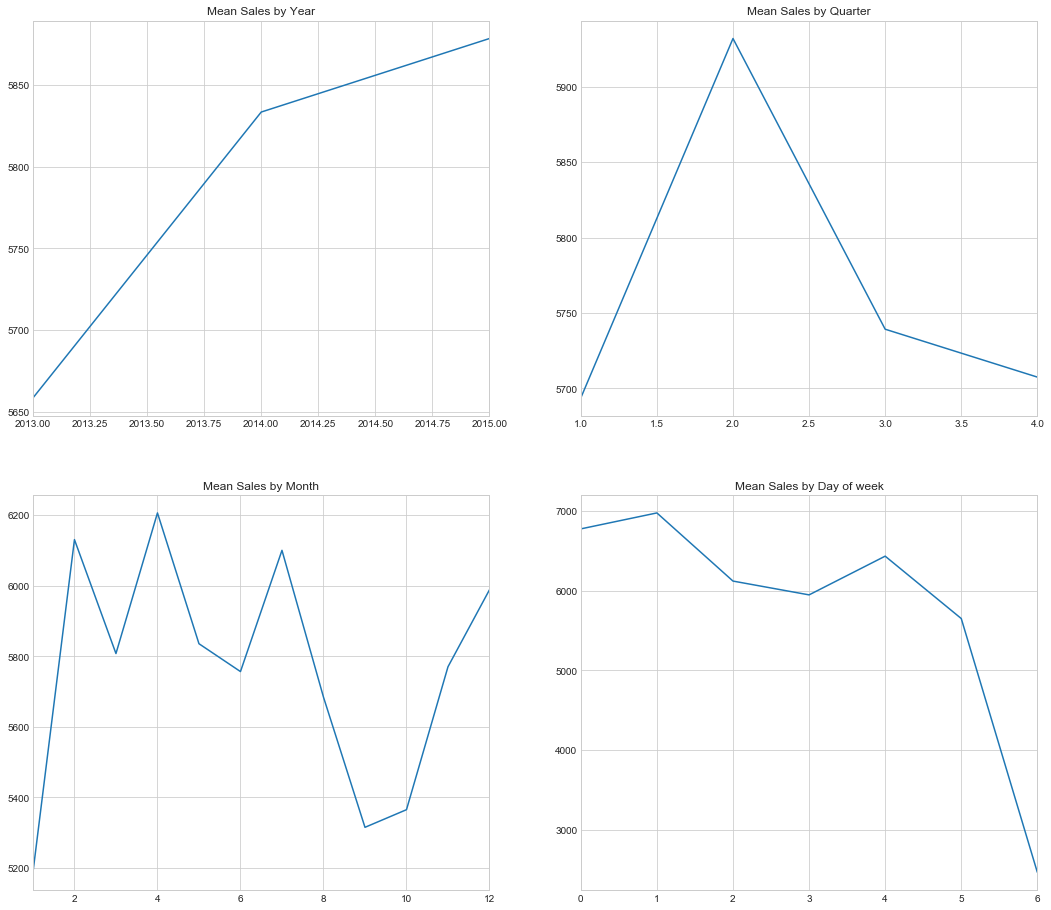

In [31]:
fig = plt.figure(figsize=(18,16))

plt.subplot(2,2,1)
df.groupby('year').Sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Year')

plt.subplot(2,2,2)
df.groupby('quarter').Sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Quarter')

plt.subplot(2,2,3)
df.groupby('month').Sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Month')

plt.subplot(2,2,4)
df.groupby('day_of_week').Sales.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Sales by Day of week');

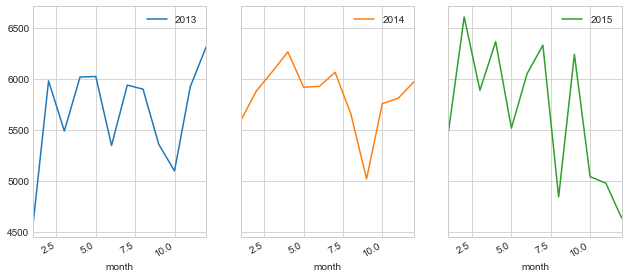

In [33]:
# df = df.reset_index(drop = True)

pd.pivot_table(df, values = "Sales", 
               columns = "year", index = "month").plot(subplots = True,
                                                       figsize=(18, 16), 
                                                       layout=(3, 5), 
                                                       sharey=True);

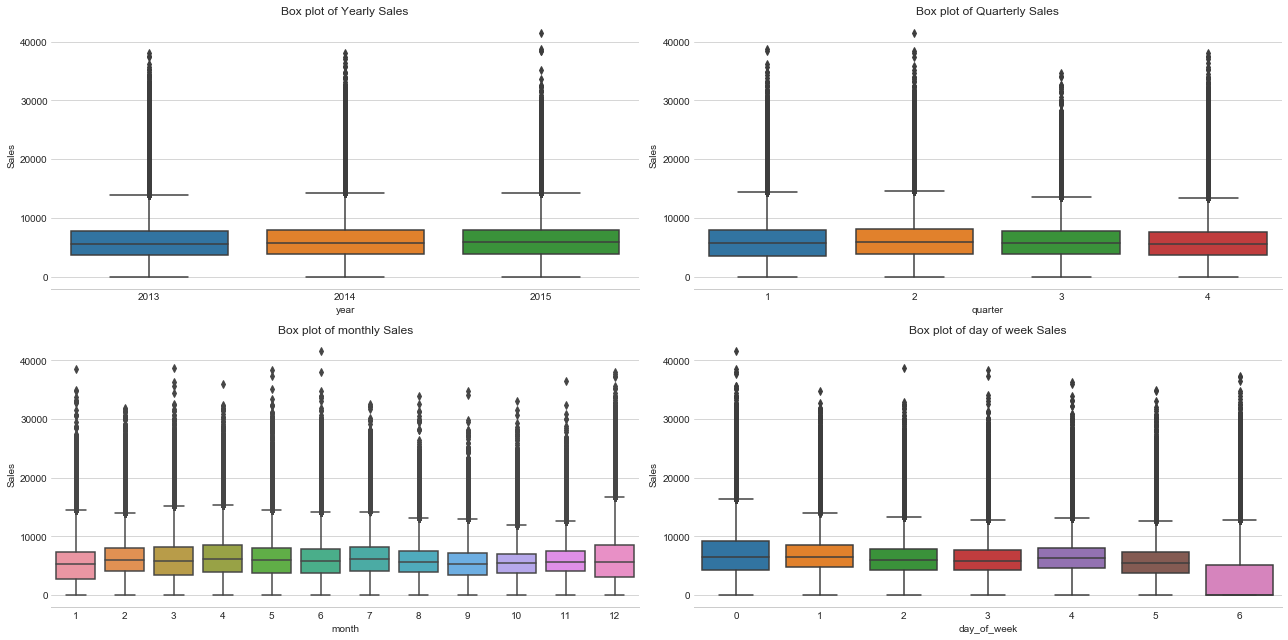

In [35]:
plt.figure(figsize=(18,9))
plt.subplot(2,2,1)
plt.subplots_adjust(wspace=0.2)

sns.boxplot(x="year", y="Sales", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Sales')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,2)
sns.boxplot(x="quarter", y="Sales", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Sales')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,3)
sns.boxplot(x="month", y="Sales", data=df)
plt.xlabel('month')
plt.title('Box plot of monthly Sales')
sns.despine(left=True)
plt.tight_layout();

plt.subplot(2,2,4)
sns.boxplot(x="day_of_week", y="Sales", data=df)
plt.xlabel('day_of_week')
plt.title('Box plot of day of week Sales')
sns.despine(left=True)
plt.tight_layout();

# StateHoliday 

In [36]:
def SH(c):
    if c['StateHoliday'] == 'a':
        return 1
    elif c['StateHoliday'] == 'b':
        return 1
    elif c['StateHoliday'] == 'c':
        return 1
    else:
        return 0
    
df['IsStateHoliday'] = df.apply(SH, axis = 1)

C:\Users\ke117\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



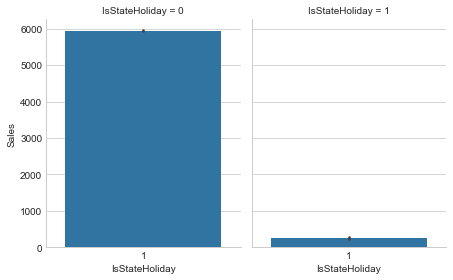

In [37]:
g = sns.FacetGrid(df, 
                 col = 'IsStateHoliday', 
                 height = 4, aspect = .8)

g.map(sns.barplot, 'IsStateHoliday', 'Sales');

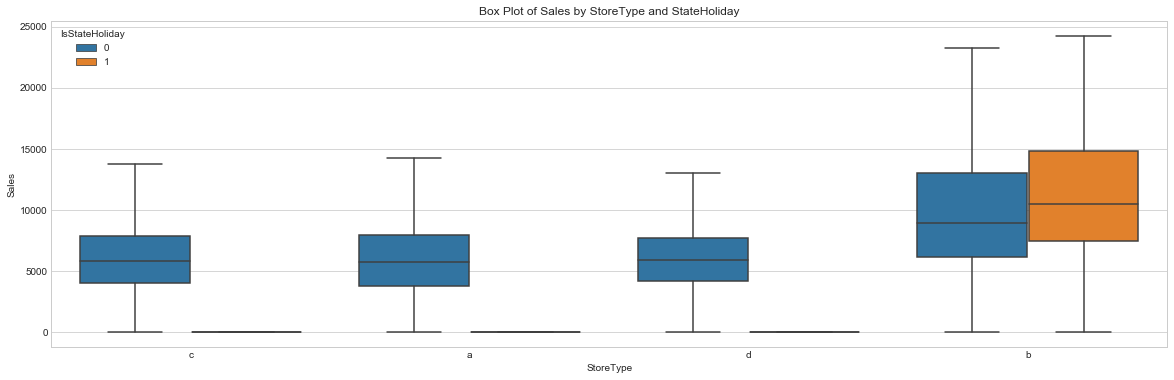

In [38]:
data = pd.concat([df['StoreType'], df['Sales'], df['IsStateHoliday']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Sales by StoreType and StateHoliday')
fig = sns.boxplot(x='StoreType', y='Sales', 
                  data=data, showfliers=False, hue="IsStateHoliday")

In [39]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,PromoInterval,quarter,weekday,year,month,day,week_of_year,day_of_year,day_of_week,IsStateHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,c,a,...,x,3,1,2015,7,31,31,212,4,0
2015-07-30,1,4,5020,546,1,1,0,1,c,a,...,x,3,1,2015,7,30,31,211,3,0
2015-07-29,1,3,4782,523,1,1,0,1,c,a,...,x,3,1,2015,7,29,31,210,2,0
2015-07-28,1,2,5011,560,1,1,0,1,c,a,...,x,3,1,2015,7,28,31,209,1,0
2015-07-27,1,1,6102,612,1,1,0,1,c,a,...,x,3,1,2015,7,27,31,208,0,0


In [40]:
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)

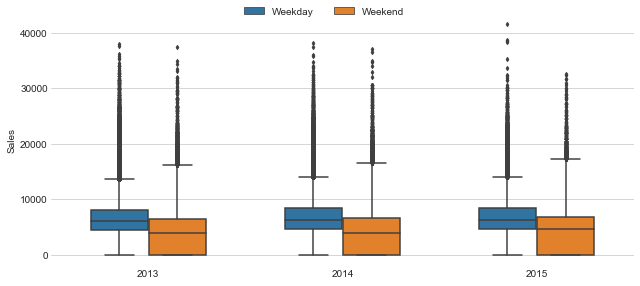

In [41]:
# Weekend / Weekday

dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 

plt1=sns.boxplot('year','Sales',
                 hue='Day',
                 width=0.6,
                 fliersize=3,
                 data=df)     

a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

C:\Users\ke117\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

C:\Users\ke117\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



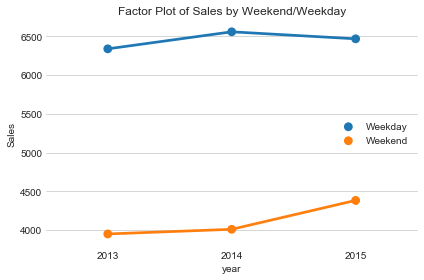

In [42]:
plt1=sns.factorplot('year','Sales',hue='Day',
                    data=df, height=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Sales by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='right');

In [43]:
sales_df = pd.DataFrame(data={'Sales':df['Sales'], 
                              'IsStateHoliday':df['IsStateHoliday']})

# GroupBy to see sales difference between 0 and 1 (StateHoliday)
sales_df['Sales'] = sales_df['Sales'].groupby(sales_df['IsStateHoliday']).transform('sum')

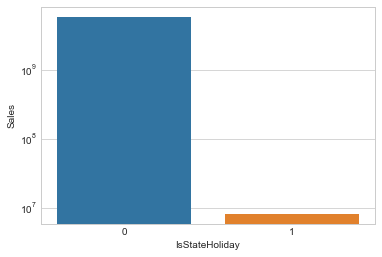

In [44]:
sns.barplot(x='IsStateHoliday', y='Sales', data=sales_df).set_yscale('log')

#sns.barplot(x='IsStateHoliday', y='Sales', data=sales_df)

# Stat test 

- D'Agostino K-sq test
    - quantify if data is drawn from Gaussian / Normal distribution
   
- Dickey-Fuller
    - Stationarity test

In [45]:
import math
from scipy import stats 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf

stat, p = stats.normaltest(df.Sales)

# H0 = not normal 
# H1 = normal 
# P <= alpha: reject H0 in favor of H1 
# P > alpha: fail to reject H0
print('Statistics = %.3f, p = %.3f' % (stat, p))

alpha = .05
2
if p > alpha:
    print('Not normally distributed (do not reject H0)')
else:
    print('Is normally distributed (reject H0)')

Statistics = 99895.452, p = 0.000
Is normally distributed (reject H0)


In [62]:
df1 = pd.read_csv('allstore.csv')

df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace = True)

df1.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Unnamed: 0,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,1,c,a,1270,9,2008,0,x,x,x
2015-07-30,1,4,5020,546,1,1,0,1,1,c,a,1270,9,2008,0,x,x,x
2015-07-29,1,3,4782,523,1,1,0,1,1,c,a,1270,9,2008,0,x,x,x
2015-07-28,1,2,5011,560,1,1,0,1,1,c,a,1270,9,2008,0,x,x,x
2015-07-27,1,1,6102,612,1,1,0,1,1,c,a,1270,9,2008,0,x,x,x


C:\Users\ke117\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)



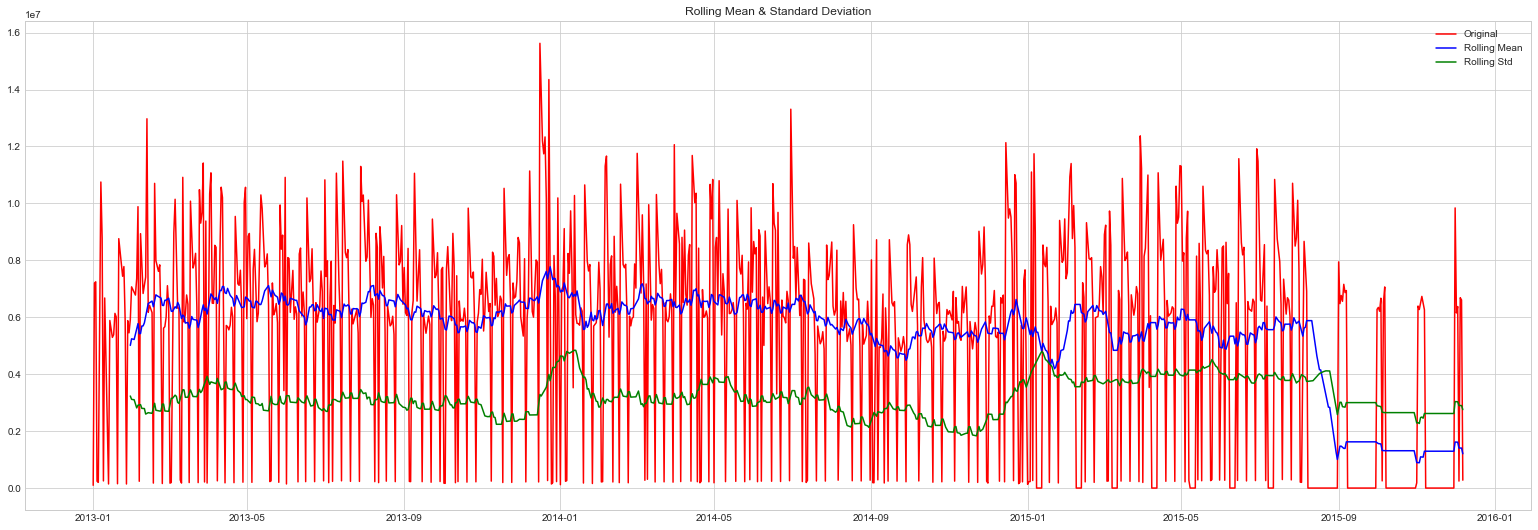

<Results of Dickey-Fuller Test>
Test Statistic                   -4.085434
p-value                           0.001024
#Lags Used                       22.000000
Number of Observations Used    1048.000000
Critical Value (1%)              -3.436605
Critical Value (5%)              -2.864302
Critical Value (10%)             -2.568240
dtype: float64


In [64]:
# Dickey-Fuller 
df1=df1.resample('D', how=np.sum)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean() # 30 days 
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(27,9))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='red',label='Original')
    mean = plt.plot(rolmean, color='blue', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df1.Sales.dropna())

#### p-val > 0.05 = Do not reject H0
- H0: data has unit root and is non-stationary 

#### p-val < 0.05 = Reject H0 
- data does not have unit root and is stationary

#### critical values 
- must be close to test statistic 

In [49]:
df.reset_index(inplace=True)
df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,quarter,weekday,year,month,day,week_of_year,day_of_year,day_of_week,IsStateHoliday,Day
0,2015-07-31,1,5,5263,555,1,1,0,1,c,...,3,1,2015,7,31,31,212,4,0,Weekday
1,2015-07-30,1,4,5020,546,1,1,0,1,c,...,3,1,2015,7,30,31,211,3,0,Weekday
2,2015-07-29,1,3,4782,523,1,1,0,1,c,...,3,1,2015,7,29,31,210,2,0,Weekday
3,2015-07-28,1,2,5011,560,1,1,0,1,c,...,3,1,2015,7,28,31,209,1,0,Weekday
4,2015-07-27,1,1,6102,612,1,1,0,1,c,...,3,1,2015,7,27,31,208,0,0,Weekday


In [50]:
# df.to_csv('model_data.csv', index = False)

# Encoding cats 

In [65]:
df = pd.read_csv('model_data.csv')
df.sort_values(by = ['Date'], inplace = True)
df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,quarter,weekday,year,month,day,week_of_year,day_of_year,day_of_week,IsStateHoliday,Day
1017208,2013-01-01,1115,2,0,0,0,0,a,1,d,...,1,1,2013,1,1,1,1,1,1,Weekday
264185,2013-01-01,291,2,0,0,0,0,a,1,d,...,1,1,2013,1,1,1,1,1,1,Weekday
444769,2013-01-01,487,2,0,0,0,0,a,1,d,...,1,1,2013,1,1,1,1,1,1,Weekday
874305,2013-01-01,959,2,0,0,0,0,a,1,a,...,1,1,2013,1,1,1,1,1,1,Weekday
590543,2013-01-01,648,2,0,0,0,0,a,1,d,...,1,1,2013,1,1,1,1,1,1,Weekday


In [66]:
x = pd.get_dummies(df, columns = ['StateHoliday','StoreType'])
x.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Assortment,CompetitionDistance,...,IsStateHoliday,Day,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d
1017208,2013-01-01,1115,2,0,0,0,0,1,c,5350,...,1,Weekday,0,1,0,0,0,0,0,1
264185,2013-01-01,291,2,0,0,0,0,1,a,540,...,1,Weekday,0,1,0,0,0,0,0,1
444769,2013-01-01,487,2,0,0,0,0,1,c,2180,...,1,Weekday,0,1,0,0,0,0,0,1
874305,2013-01-01,959,2,0,0,0,0,1,c,1060,...,1,Weekday,0,1,0,0,1,0,0,0
590543,2013-01-01,648,2,0,0,0,0,1,a,2130,...,1,Weekday,0,1,0,0,0,0,0,1


In [67]:
x.to_csv('regression.csv')